## EDA - DPE v2 Logements Existants

In [275]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from datetime import datetime

In [276]:
data = pd.read_csv("dpe-v2-logements-existants_Q4-24.csv", sep=",")

/var/folders/hj/bscrbp2d62s66kpl23mz_f_w0000gn/T/ipykernel_27638/1301349527.py:1: DtypeWarning: Columns (11,102,112,190,191,192,193,226,237) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("dpe-v2-logements-existants_Q4-24.csv", sep=",")


# Overall look at the data

In [56]:
# print(data.head())
# print(data.info())

# Type of data

In [277]:
"""
On classe les colonnes en fonction de leur type
"""

data_type = data

column_classification = {
    "Quantitative_Continues": [],
    "Quantitative_Discretes": [],
    "Qualitative_Nominales": [],
    "Qualitative_Ordinales": [],
    "Binaires": [],
    "Dates": []
}

# Ensembles de référence pour détecter les colonnes ordinales
known_ordinal_sets = [
    ['A', 'B', 'C', 'D', 'E', 'F', 'G'],
    ['faible', 'moyen', 'élevé'],
    ['insuffisante', 'moyenne', 'bonne'],
    ['Lourde', 'Moyenne', 'Légère']
]

# Parcourir les colonnes pour les classifier automatiquement
for col in data_type.columns:
    # Ignorer les colonnes entièrement vides
    if data_type[col].isnull().all():
        continue
    
    unique_values = data_type[col].dropna().unique()
    num_unique = len(unique_values)

    # Vérifier si c'est une colonne binaire (0 ou 1 uniquement)
    if set(unique_values).issubset({0, 1}):
        column_classification["Binaires"].append(col)

    # Vérifier si c'est une colonne temporelle (date)
    elif pd.api.types.is_datetime64_any_dtype(data_type[col]) or "Date" in col or "Période" in col:
        column_classification["Dates"].append(col)

    # Vérifier si c'est une variable quantitative discrète ou continue
    elif pd.api.types.is_numeric_dtype(data_type[col]):
        # Vérifier si toutes les valeurs sont des entiers (même si float64)
        all_integers = all(float(val).is_integer() for val in unique_values)

        if num_unique < 10000 and all_integers:
            column_classification["Quantitative_Discretes"].append(col)
        else:
            column_classification["Quantitative_Continues"].append(col)

    # Vérifier si c'est une variable qualitative ordinale
    elif pd.api.types.is_string_dtype(data_type[col]) or num_unique < 50:  # Heuristique pour catégorisation
        # Vérifier si toutes les valeurs uniques sont dans un ensemble de référence
        is_ordinal = False
        for ordinal_set in known_ordinal_sets:
            if any(val in ordinal_set for val in unique_values):
                column_classification["Qualitative_Ordinales"].append(col)
                is_ordinal = True
                break
        # Si ce n'est pas ordinale, l'ajouter comme nominale
        if not is_ordinal:
            column_classification["Qualitative_Nominales"].append(col)
    
    # Parcourir les colonnes restantes non classées
    classified_columns = (
        column_classification["Quantitative_Continues"] +
        column_classification["Quantitative_Discretes"] +
        column_classification["Qualitative_Nominales"] +
        column_classification["Qualitative_Ordinales"] +
        column_classification["Binaires"] +
        column_classification["Dates"]
    )

for col in data_type.columns:
    if col not in classified_columns:
        # Classer les colonnes non classées comme nominales
        column_classification["Qualitative_Nominales"].append(col)

# Afficher les résultats
for key, cols in column_classification.items():
    print(f"{key}:")
    for idx, col in enumerate(cols):
        col_index = data_type.columns.get_loc(col)
        print(f"  {col_index}: {col}")


Quantitative_Continues:
  7: Version_DPE
  21: Hauteur_sous-plafond
  26: Surface_habitable_logement
  40: Score_BAN
  42: Coordonnée_cartographique_X_(BAN)
  43: Coordonnée_cartographique_Y_(BAN)
  53: Conso_5_usages_é_finale
  54: Conso_5_usages/m²_é_finale
  55: Conso_chauffage_é_finale
  56: Conso_chauffage_dépensier_é_finale
  57: Conso_éclairage_é_finale
  58: Conso_ECS_é_finale
  59: Conso_ECS_dépensier_é_finale
  60: Conso_refroidissement_é_finale
  61: Conso_refroidissement_dépensier_é_finale
  62: Conso_auxiliaires_é_finale
  63: Conso_5_usages_é_primaire
  64: Conso_5_usages_par_m²_é_primaire
  65: Conso_chauffage_é_primaire
  66: Conso_chauffage_dépensier_é_primaire
  67: Conso_éclairage_é_primaire
  68: Conso_ECS_é_primaire
  69: Conso_ECS_dépensier_é_primaire
  70: Conso_refroidissement_é_primaire
  71: Conso_refroidissement_dépensier_é_primaire
  72: Conso_auxiliaires_é_primaire
  73: Emission_GES_5_usages
  74: Emission_GES_5_usages_par_m²
  75: Emission_GES_chauffage
 

# Target columnn

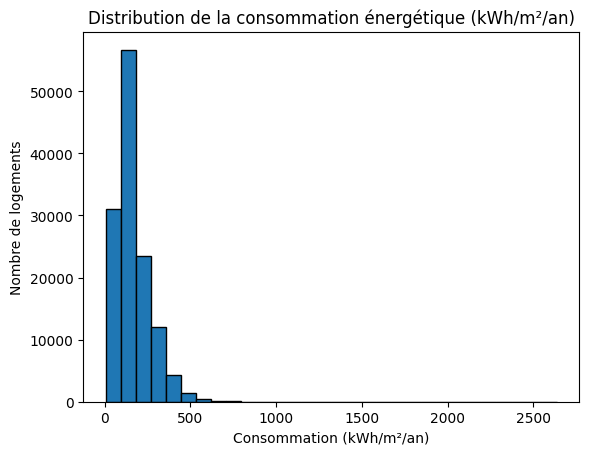

In [278]:
# Cette colonne a l'air cohérente avec la consommation moyenne des Français par m2/an (161 kWh en 2022)
y = data["Conso_5_usages/m²_é_finale"]

plt.hist(y.dropna(), bins=30, edgecolor="k")
plt.title("Distribution de la consommation énergétique (kWh/m²/an)")
plt.xlabel("Consommation (kWh/m²/an)")
plt.ylabel("Nombre de logements")
plt.show()

# Handling missing values

In [279]:
# Résumé des valeurs manquantes pour chaque colonne
missing_summary = data.isnull().sum().reset_index()
missing_summary.columns = ["Column", "Missing Values"]
missing_summary["Missing Percentage"] = (missing_summary["Missing Values"] / len(data)) * 100

# Trier par pourcentage décroissant
missing_summary = missing_summary.sort_values(by="Missing Percentage", ascending=False)

# Configurer pandas pour afficher toutes les colonnes
pd.set_option('display.max_rows', None)  # Afficher toutes les lignes
pd.set_option('display.max_columns', None)  # Afficher toutes les colonnes

# Afficher toutes les colonnes
print(missing_summary)

# Réinitialiser les options si nécessaire
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')


                                                Column  Missing Values  \
12                           Invariant_fiscal_logement          129597   
8                              N°_DPE_immeuble_associé          129597   
27                          Surface_tertiaire_immeuble          129597   
25                          Surface_habitable_immeuble          129597   
30                     Position_logement_dans_immeuble          129597   
29                                  Typologie_logement          129597   
19                     Type_installation_ECS_(général)          129597   
18                         Type_installation_chauffage          129597   
220                    Type_énergie_générateur_ECS_n°2          129597   
221                            Type_générateur_ECS_n°2          129597   
222                           Usage_générateur_ECS_n°2          129597   
215                  Conso_é_finale_générateur_ECS_n°2          129597   
217                             COP_gé

In [280]:
"""
On s'aperçoit qu'il y a beaucoup de colonnes contenant énormément de valeurs manquantes. Après analyse de ces dernières,
on décide d'enlever les colonnes pour lesquelles le taux de valeurs manquantes est supérieur à 1%
(ces colonnes ne sont de toute façon pas pertinentes pour notre analyse).
"""
# Calculer le pourcentage de valeurs manquantes
missing_percentage = data.isnull().mean() * 100

# Sélectionner les colonnes à conserver (celles avec moins de 1 % de valeurs manquantes)
columns_to_keep = missing_percentage[missing_percentage <= 1].index

# Créer un nouveau DataFrame sans les colonnes avec plus de 1 % de valeurs manquantes
data = data[columns_to_keep]

# Afficher le résultat
print(f"Colonnes conservées : {len(columns_to_keep)}")


Colonnes conservées : 136


In [281]:
"""
Gestion des valeurs manquantes en fonction de leur type
"""

# Quantitative_Continues et Quantitative_Discretes
# On prend la médiane pour ne pas être trop affecté par les outliers
for col in column_classification["Quantitative_Continues"] + column_classification["Quantitative_Discretes"]:
    if col in data.columns:  # Vérifie si la colonne existe
        data.loc[:, col] = data[col].fillna(data[col].median())

# Qualitative_Nominales et Qualitative_Ordinales
# On prend le mode pour remplacer les valeurs manquantes par la valeur la plus fréquente dans le dataset
for col in column_classification["Qualitative_Nominales"] + column_classification["Qualitative_Ordinales"]:
    if col in data.columns:  # Vérifie si la colonne existe
        data.loc[:, col] = data[col].fillna(data[col].mode()[0])

# Binaires
# On enlève les lignes pour lesquelles la valeur est manquante (juste 2 valeurs manquantes pour Isolation_toiture_(0/1))
for col in column_classification["Binaires"]:
    if col in data.columns:  # Vérifie si la colonne existe
        data = data.dropna(subset=[col]) 

In [282]:
# Vérifie si des valeurs manquantes sont présentes dans le DataFrame
missing_values = data.isnull().sum()

# Affiche uniquement les colonnes avec des valeurs manquantes
missing_report = missing_values[missing_values > 0]

if missing_report.empty:
    print("Aucune valeur manquante dans le DataFrame.")
else:
    print("Colonnes avec des valeurs manquantes :")
    print(missing_report)


Aucune valeur manquante dans le DataFrame.


# Variable transformation

In [284]:
"""
On transforme les variables ordinales
"""

# Définir les mappings spécifiques en fonction du préfixe du nom des colonnes
ordinal_mappings = {
    "Etiquette": {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7},
    "Classe": {'Légère': 1, 'Moyenne': 2, 'Lourde': 3, 'Très lourde': 4},
    "Indicateur": {'bon': 1, 'moyen': 2, 'insuffisant': 3},
    "Qualité": {'très bonne': 1, 'bonne': 2, 'moyenne': 3, 'insuffisante': 4}
}

# Parcourir les colonnes Qualitative_Ordinales
for col in column_classification["Qualitative_Ordinales"]:
    if col in data.columns:
        # Vérifier si le nom de la colonne commence par une clé dans ordinal_mappings
        for prefix, mapping in ordinal_mappings.items():
            if col.startswith(prefix):
                # Appliquer le mapping correspondant
                data[col] = data[col].map(mapping).astype('float')  # Conversion explicite en float
                break  # Passer à la colonne suivante une fois le mapping trouvé


In [285]:
"""
On transforme les variables dates comme une différence par rapport à une date de référence
"""

# Date de référence
date_ref = pd.Timestamp('2025-01-01')

# Mapping des périodes
periode_mapping = {
    'avant 1948': 1947,
    '1948-1974': 1961,
    '1975-1977': 1976,
    '1978-1982': 1980,
    '1983-1988': 1985,
    '1989-2000': 1995,
    '2001-2005': 2003,
    '2006-2012': 2009,
    '2013-2021': 2017,
    'après 2021': 2023
}

# Parcourir les colonnes
for col in column_classification["Dates"]:
    if col in data.columns:  # Vérifie si la colonne existe
        if col.startswith("Date"):
            # Convertir en datetime
            data[col] = pd.to_datetime(data[col], errors='coerce')
            # Vérifier que la colonne est bien de type datetime avant d'utiliser .dt
            if pd.api.types.is_datetime64_any_dtype(data[col]):
                # Calculer la différence en années et remplacer la colonne
                data.loc[:, col] = (date_ref - data[col]).dt.days / 365.25
        elif col.startswith("Période"):
            # Mapper les périodes puis calculer la différence en années
            data.loc[:, col] = data[col].map(periode_mapping)
            # Vérifier que le mapping a réussi
            if data[col].notnull().all():
                data.loc[:, col] = date_ref.year - data[col]


/var/folders/hj/bscrbp2d62s66kpl23mz_f_w0000gn/T/ipykernel_27638/1237024064.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.12046543 0.15331964 0.21081451 ... 0.1779603  0.15879535 0.19164956]' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  data.loc[:, col] = (date_ref - data[col]).dt.days / 365.25
/var/folders/hj/bscrbp2d62s66kpl23mz_f_w0000gn/T/ipykernel_27638/1237024064.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.12320329 0.15605749 0.21355236 ... 0.1889117  0.1615332  0.19438741]' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  data.loc[:, col] = (date_ref - data[col]).dt.days / 365.25
/var/folders/hj/bscrbp2d62s66kpl23mz_f_w0000gn/T/ipykernel_27638/1237024064.py:31: FutureWarning: Setting an item of incompatible dtype is

In [286]:
"""
Après analyse des valeurs uniques pour les types Qualitative_Nominales, nous trouvons pertinent de garder
Classe_altitude et Zone_climatique_
Le reste des colonnes est supprimé.
"""

# Parcourir les colonnes Qualitative_Nominales
for col in column_classification["Qualitative_Nominales"]:
    if col in data.columns:  # Vérifie que la colonne existe dans le DataFrame
        # Vérifier le nombre de valeurs uniques
        num_unique = data[col].nunique()
        
        # Si le nombre de valeurs uniques est inférieur à 50
        if num_unique < 50:
            # Afficher les valeurs uniques
            print(f"Valeurs uniques pour la colonne '{col}' (moins de 50 valeurs uniques) :")
            print(data[col].unique())
            print(f"Nombre de valeurs uniques : {num_unique}")
            print("-" * 50)

Valeurs uniques pour la colonne 'Modèle_DPE' (moins de 50 valeurs uniques) :
['DPE 3CL 2021 méthode logement']
Nombre de valeurs uniques : 1
--------------------------------------------------
Valeurs uniques pour la colonne 'Méthode_application_DPE' (moins de 50 valeurs uniques) :
['dpe maison individuelle']
Nombre de valeurs uniques : 1
--------------------------------------------------
Valeurs uniques pour la colonne 'Type_bâtiment' (moins de 50 valeurs uniques) :
['maison']
Nombre de valeurs uniques : 1
--------------------------------------------------
Valeurs uniques pour la colonne 'Classe_altitude' (moins de 50 valeurs uniques) :
['inférieur à 400m' '400-800m' 'supérieur à 800m']
Nombre de valeurs uniques : 3
--------------------------------------------------
Valeurs uniques pour la colonne 'Zone_climatique_' (moins de 50 valeurs uniques) :
['H1a' 'H2c' 'H3' 'H1b' 'H2a' 'H1c' 'H2b' 'H2d']
Nombre de valeurs uniques : 8
--------------------------------------------------
Valeurs un

In [287]:
"""
On transforme certaines variables nominales
"""

nominal_mappings = {
    "Classe_altitude": {'inférieur à 400m': 1, '400-800m': 2, 'supérieur à 800m': 3},
}

# Fonction pour transformer les valeurs de Zone_climatique_ selon le préfixe
def map_zone_climatique(value):
    if value.startswith('H3'):
        return 1
    elif value.startswith('H2'):
        return 2
    elif value.startswith('H1'):
        return 3

# Parcourir les colonnes Qualitative_Nominales
for col in column_classification["Qualitative_Nominales"]:
    if col in data.columns:
            if col == "Zone_climatique_":
                data[col] = data[col].apply(map_zone_climatique)  # Appliquer la transformation spécifique
            elif col == "Classe_altitude":
                 for key, mapping in nominal_mappings.items():
                    if col == key:
                        data[col] = data[col].map(mapping).astype('float')  # Transformation en valeurs numériques
                        break
            else:
                data = data.drop(columns=[col])

In [288]:
"""
Récapitulatif des colonnes conservées et de leurs types
"""

# Affichage des colonnes classées par type
for col_type, columns in column_classification.items():
    print(f"{col_type}:")
    for col in columns:
        if col in data.columns:  # Vérifie si la colonne existe toujours
            print(f"  - {col}")
    print()  # Ligne vide pour séparer les types

Quantitative_Continues:
  - Version_DPE
  - Hauteur_sous-plafond
  - Surface_habitable_logement
  - Score_BAN
  - Coordonnée_cartographique_X_(BAN)
  - Coordonnée_cartographique_Y_(BAN)
  - Conso_5_usages_é_finale
  - Conso_5_usages/m²_é_finale
  - Conso_chauffage_é_finale
  - Conso_chauffage_dépensier_é_finale
  - Conso_éclairage_é_finale
  - Conso_ECS_é_finale
  - Conso_ECS_dépensier_é_finale
  - Conso_refroidissement_é_finale
  - Conso_refroidissement_dépensier_é_finale
  - Conso_auxiliaires_é_finale
  - Conso_5_usages_é_primaire
  - Conso_5_usages_par_m²_é_primaire
  - Conso_chauffage_é_primaire
  - Conso_chauffage_dépensier_é_primaire
  - Conso_éclairage_é_primaire
  - Conso_ECS_é_primaire
  - Conso_ECS_dépensier_é_primaire
  - Conso_refroidissement_é_primaire
  - Conso_refroidissement_dépensier_é_primaire
  - Conso_auxiliaires_é_primaire
  - Emission_GES_5_usages
  - Emission_GES_5_usages_par_m²
  - Emission_GES_chauffage
  - Emission_GES_chauffage_dépensier
  - Emission_GES_écla

# Outliers on target variable

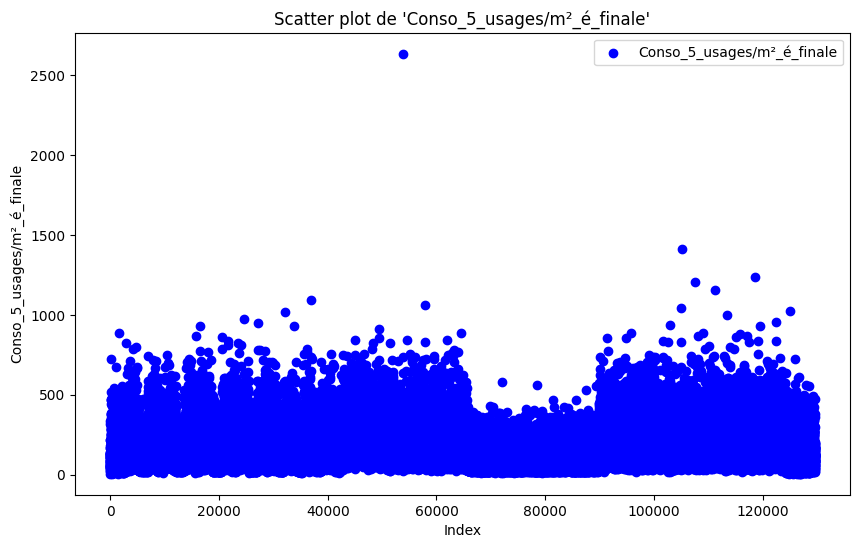

In [289]:
"""
On va détecter les outliers avec la méthode des quantiles.
"""

colonne = "Conso_5_usages/m²_é_finale"

# Visualiser les résultats avec un scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(data.index, data[colonne], color='blue', label=colonne)
plt.title(f"Scatter plot de '{colonne}'")
plt.xlabel("Index")
plt.ylabel(colonne)
plt.legend()
plt.show()


In [299]:
# Définir la colonne dynamique
colonne = "Conso_5_usages/m²_é_finale"

# Calculer les quartiles
Q1 = data[colonne].quantile(0.25)
Q3 = data[colonne].quantile(0.75)
IQR = Q3 - Q1

# Définir les bornes pour les outliers
lower_bound = Q1 - 2 * IQR
upper_bound = Q3 + 2 * IQR

# Identifier les outliers
outliers = data[(data[colonne] < lower_bound) | (data[colonne] > upper_bound)]

# Afficher les valeurs des outliers détectés
print("Valeurs des outliers détectés :")
print(outliers[colonne].values)

# Afficher le nombre d'outliers détectés
print(f"Nombre d'outliers détectés : {outliers.shape[0]}")


Valeurs des outliers détectés :
[471.1 518.4 466.8 ... 459.9 490.5 475.7]
Nombre d'outliers détectés : 2325


In [301]:
"""
On enlève les outliers détectés sur notre target variable.
(outliers possibles sur les autres features)
"""

# Supprimer les lignes contenant des outliers
data = data[(data[colonne] >= lower_bound) & (data[colonne] <= upper_bound)]
print(f"Nombre de lignes après suppression des outliers : {data.shape[0]}")

Nombre de lignes après suppression des outliers : 127270


# Correlation with the target variable

In [302]:
# Définir la colonne target y
y = "Conso_5_usages/m²_é_finale"

# Filtrer les colonnes pertinentes dans le DataFrame
data_for_corr = data[data.columns]

# Calculer la matrice de corrélation
correlation_matrix = data_for_corr.corr()

# Extraire les corrélations avec la variable cible 'y'
correlations_with_y = correlation_matrix[y].drop(y)  # Exclure la corrélation de 'y' avec elle-même

# Définir des seuils pour les différentes forces de corrélation
thresholds = {
    'Modérée': 0.4,
    'Forte': 0.6,
    'Très forte': 0.8
}

# Créer des listes pour chaque catégorie de corrélation
moderate_correlations = correlations_with_y[(correlations_with_y.abs() > thresholds['Modérée']) & (correlations_with_y.abs() <= thresholds['Forte'])]
strong_correlations = correlations_with_y[(correlations_with_y.abs() > thresholds['Forte']) & (correlations_with_y.abs() <= thresholds['Très forte'])]
very_strong_correlations = correlations_with_y[correlations_with_y.abs() > thresholds['Très forte']]

# Afficher les résultats
print("Colonnes avec une corrélation modérée avec la variable cible y:")
print(moderate_correlations)

print("\nColonnes avec une corrélation forte avec la variable cible y:")
print(strong_correlations)

print("\nColonnes avec une corrélation très forte avec la variable cible y:")
print(very_strong_correlations)


Colonnes avec une corrélation modérée avec la variable cible y:
Période_construction                    0.492715
Conso_5_usages_é_primaire               0.530948
Conso_chauffage_é_primaire              0.568942
Conso_chauffage_dépensier_é_primaire    0.558946
Coût_total_5_usages_énergie_n°1         0.511000
Coût_chauffage_énergie_n°1              0.572724
Emission_GES_5_usages_énergie_n°1       0.597901
Coût_total_5_usages                     0.572002
Coût_chauffage                          0.590051
Coût_chauffage_dépensier                0.580870
Deperditions_enveloppe                  0.434817
Déperditions_murs                       0.521557
Qualité_isolation_murs                  0.585688
Qualité_isolation_plancher_bas          0.423037
Besoin_chauffage                        0.571153
Name: Conso_5_usages/m²_é_finale, dtype: float64

Colonnes avec une corrélation forte avec la variable cible y:
Conso_5_usages_é_finale                                      0.688657
Conso_chauffage_é_f

# Thoughts

In [ ]:
"""
J'ai testé une régression linéaire avec les features suivantes:
features = [
    "Période_construction",
    "Isolation_toiture_(0/1)",
    "Deperditions_planchers_hauts",
    "Qualité_isolation_enveloppe",
    "Qualité_isolation_murs",
    "Qualité_isolation_plancher_bas",
    "Etiquette_GES",
    "Etiquette_DPE"
]

J'ai délibéremment choisit de ne pas prendre les colonnes liées à des coûts ou de la conso, qui sont forcément très corrélées à la conso énergétique.
R-squared: 84% (sur test)
"""